# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Скачиваю необходимые библиотеки

#Lightgbm
try:
    import lightgbm as lgbm
    print('LightGBM ver.:', lgbm.__version__)
except:
    !pip install lightgbm

#Optuna    
try:
    import optuna
    print('Optuna ver.:', optuna.__version__)
except:
    !pip install optuna
    import optuna
    
!pip install --upgrade matplotlib

LightGBM ver.: 3.3.1
Optuna ver.: 3.1.0


In [2]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Импорт данных
data = pd.read_csv('/datasets/taxi.csv', index_col=[0],parse_dates=[0])


In [5]:
#Выведу данные
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
print('Тип данных в индексах - ', data.index.dtype)

Тип данных в индексах -  datetime64[ns]


In [7]:
print('Индексы с датами упорядочены - ', data.index.is_monotonic)

Индексы с датами упорядочены -  True


In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Временной ряд содержит 26496 записей о количестве заказов в каждые 10 минут времени с марта по август 2018 года - за 6 месяцев.

Так как нас интересует среднее количество заказов в час, проведу ресемплирование по 1 часу.

In [9]:
#Семплирую временной ряд по '1H'
data = data.resample('1H').sum()

In [10]:
#Семплирую временной ряд по '1D'
data_1D = data.resample('1D').sum()

## Анализ

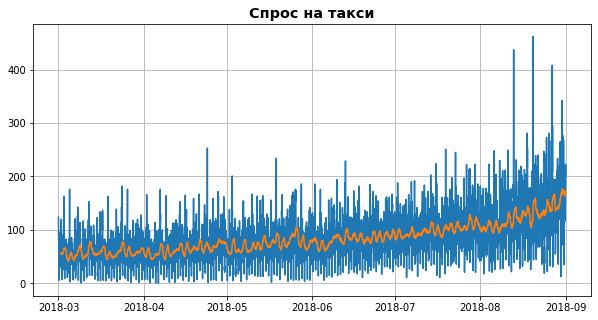

In [11]:
#Отображаю данные
plt.figure(figsize=(10,5))
plt.plot(data)
plt.plot(data.rolling(24).mean())
plt.title('Спрос на такси',fontweight='bold',fontsize='x-large')
plt.grid()
plt.show()

Видно явный тренд, по которому понятно, что кол-во заказов такси увеличивается с марта по август.

По сезонности меня интересует следующее:

- Есть ли внутрисуточная сезонность - как кол-во заказов такси зависит от часа в сутках;

- Есть ли дневная сезонность - как кол-во заказов такси зависит от дня недели, есть ли какие-либо тенденции повышенного спроса например в выходные и т.д.

In [12]:
#Использую инструмент из библиотеки statsmodels, чтобы разложить временной ряд на тренд, сезон и шум
#По данным, семплированным по часу
decomposed = seasonal_decompose(data)

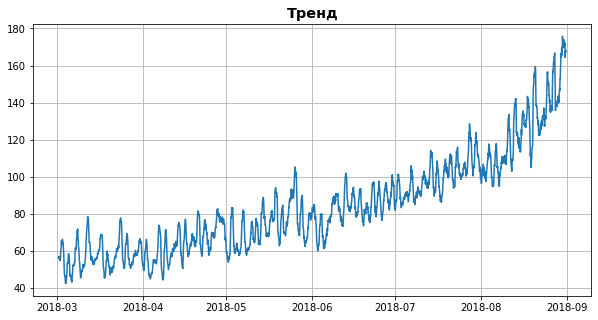

In [13]:
#Вывожу график трендновой компоненты
plt.figure(figsize=(10, 5))
plt.plot(decomposed.trend)
plt.grid()
plt.title('Тренд',fontweight='bold',fontsize='x-large')
plt.show()

In [14]:
#Список с индексами понедельников в марте
march_mondays = data_1D['2018-03'].loc[data_1D['2018-03'].index.weekday==0].index

#Список с часами для подписей оси х
xtick = []
for i in  decomposed.seasonal.loc['2018-03-05'].index.strftime('%Y-%m-%d %H:%M:%S'):
    xtick.append(i[-8:])
    
#Список с названиями дней недели
weekdays = ['ПН','ВТ','СР','ЧТ','ПТ','СБ','ВС']

#Список с месяцами
xtick_months = []
for i in  data.resample('1M').sum().index.strftime('%Y-%m-%d %H:%M:%S'):
    xtick_months.append(i[:7])

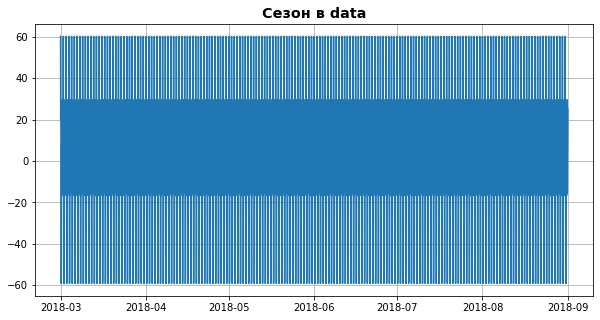

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(decomposed.seasonal)
plt.grid()
plt.title('Сезон в data',fontweight='bold',fontsize='x-large')
plt.show()

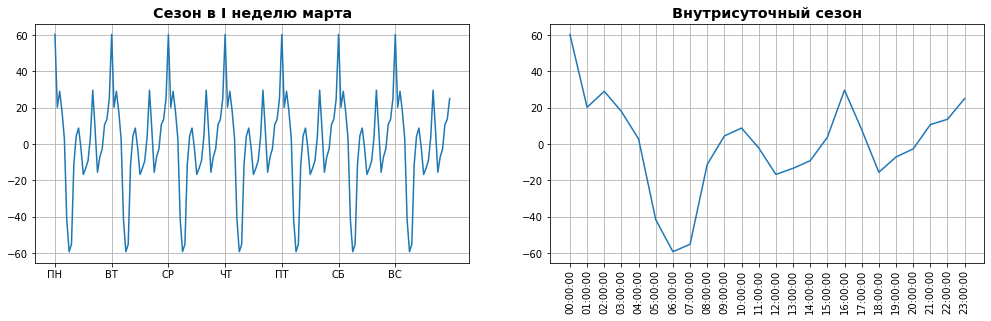

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.tight_layout(pad=5)
axs[0].plot(decomposed.seasonal.loc['2018-03-05':'2018-03-11'])
axs[0].grid()
axs[0].set_title('Сезон в I неделю марта',fontweight='bold',fontsize='x-large')
axs[0].set_xticks(data_1D.loc['2018-03-05':'2018-03-11'].index,labels=weekdays)
axs[1].plot(decomposed.seasonal.loc['2018-03-05'])
axs[1].grid()
axs[1].set_title('Внутрисуточный сезон',fontweight='bold',fontsize='x-large')
axs[1].set_xticks(decomposed.seasonal.loc['2018-03-05'].index,labels=xtick,rotation=90)
plt.show()

In [17]:
#Использую инструмент из библиотеки statsmodels, чтобы разложить временной ряд на тренд, сезон и шум
#По данным, семплированным по суткам
decomposed_1D = seasonal_decompose(data_1D, model='additive')

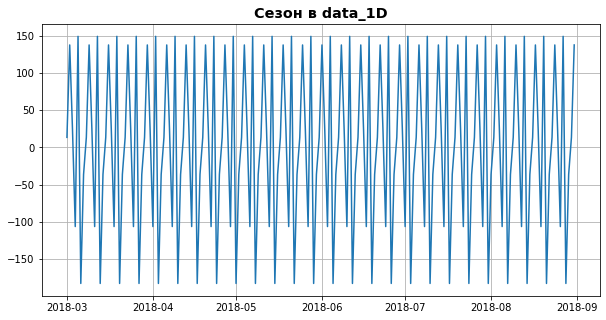

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(decomposed_1D.seasonal)
plt.grid()
plt.title('Сезон в data_1D',fontweight='bold',fontsize='x-large')
plt.show()

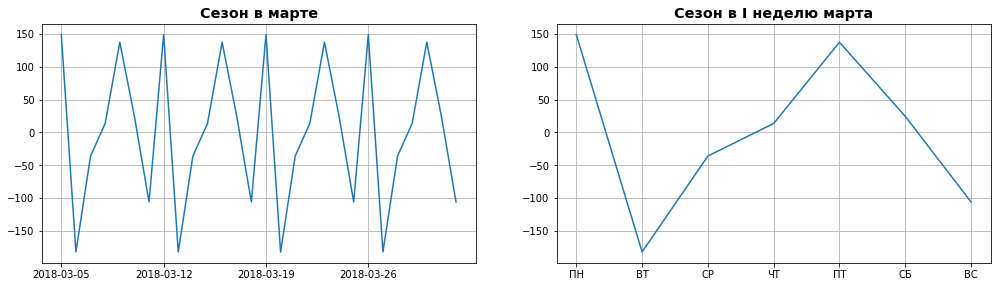

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.tight_layout(pad=5)
axs[0].plot(decomposed_1D.seasonal.loc['2018-03-05':'2018-04-01'])
axs[0].grid()
axs[0].set_title('Сезон в марте',fontweight='bold',fontsize='x-large')
axs[0].set_xticks(decomposed_1D.seasonal.loc[march_mondays].index,
                  labels=['2018-03-05', '2018-03-12', '2018-03-19', '2018-03-26'])
axs[1].plot(decomposed_1D.seasonal.loc['2018-03-05':'2018-03-11'])
axs[1].grid()
axs[1].set_title('Сезон в I неделю марта',fontweight='bold',fontsize='x-large')
axs[1].set_xticks(decomposed_1D.seasonal.loc['2018-03-05':'2018-03-11'].index,labels=weekdays)
plt.show()

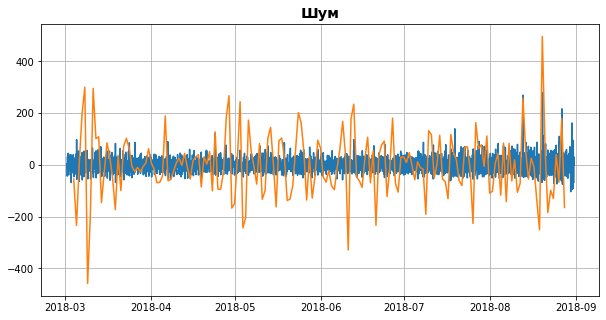

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(decomposed.resid)
plt.plot(decomposed_1D.resid)
plt.grid()
plt.title('Шум',fontweight='bold',fontsize='x-large')
plt.show()

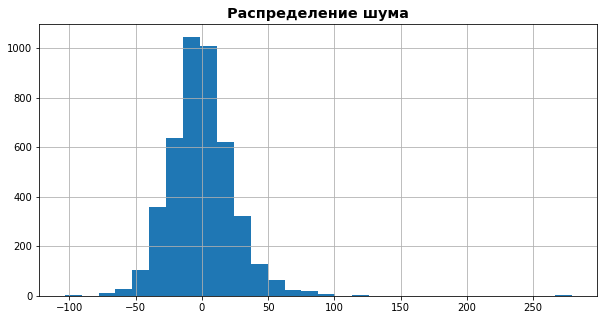

In [21]:
plt.figure(figsize=(10, 5))
plt.hist(decomposed.resid,bins=30)
plt.grid()
plt.title('Распределение шума',fontweight='bold',fontsize='x-large')
plt.show()

**Вывод:**

Временной ряд имеет следующие характеристики:

**Тренд:** явно выраженный идущий вверх.

**Сезонность в сутках:**

Пик спроса такси у аэропорта приходится на полночь, далее спадает до минимума в 06:00. С утра до вечера есть два пика повышенного спроса - в 10:00 и 16:00, самые непопулярные часы - 12:00 и 18:00.

**Сезонность на неделе:**

Понедельники и четверги -  дни, когда такси вызывают чаще всего на неделе. Самый маленький спрос на такси во вторники.

**Шум:**

Шумом без ярко выраженных тенденций. Распределен нормально со смещением вправо, что означает, что во временном ряде есть выбросы - это видно и на графике: несколько пиковых значений в августе.

## Обучение

### Подготовка признаков

Создам матрицу признаков, куда будут входить:

- календарные признаки (час, день недели);

- разности временного ряда;

- отстающие значения;

- скользящее среднее.

In [22]:
#Создаю функцию для создания новых признаков
def add_features(data, diff, lags, rolling_mean):
    data_new = data.copy()
    #Календарные
    data_new['hour'] = data_new.index.hour
    data_new['weekday'] = data_new.index.weekday
    #Разность
    for i in range(1,diff+1,1):
        data_new['diff%s' %i] = data_new['num_orders'].shift().diff(periods=i)
    #Отстающие значения
    for i in range(1,lags+1,1):
        data_new['lag%s' %i] = data_new['num_orders'].shift(i)
    #Скользящее среднее
    for i in range(1, rolling_mean+1, 1):
        data_new['rolling_mean%s' %i] = data_new['num_orders'].shift().rolling(i).mean()
    return data_new

In [23]:
#Создаю переменную c новыми признаками и таргетом
data_new = add_features(data,12,12,12)
#Удаляю строки с пропусками
data_new = data_new.dropna()
#Признаки
X = data_new.drop('num_orders', axis=1)
#Таргет
y = data_new['num_orders'].values

In [24]:
data_new.head()

,num_orders,hour,weekday,diff1,diff2,diff3,diff4,diff5,diff6,diff7,...,rolling_mean3,rolling_mean4,rolling_mean5,rolling_mean6,rolling_mean7,rolling_mean8,rolling_mean9,rolling_mean10,rolling_mean11,rolling_mean12
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 13:00:00,32,13,3,-66.0,-34.0,-39.0,-4.0,15.0,18.0,24.0,...,63.333333,64.75,58.6,51.333333,45.714286,40.750,41.000000,43.5,46.000000,49.250000
2018-03-01 14:00:00,48,14,3,2.0,-64.0,-32.0,-37.0,-2.0,17.0,20.0,...,52.666667,55.50,58.2,54.166667,48.571429,44.000,39.777778,40.1,42.454545,44.833333
2018-03-01 15:00:00,66,15,3,16.0,18.0,-48.0,-16.0,-21.0,14.0,33.0,...,36.666667,51.50,54.0,56.500000,53.285714,48.500,44.444444,40.6,40.818182,42.916667
2018-03-01 16:00:00,43,16,3,18.0,34.0,36.0,-30.0,2.0,-3.0,32.0,...,48.666667,44.00,54.4,56.000000,57.857143,54.875,50.444444,46.6,42.909091,42.916667
2018-03-01 17:00:00,44,17,3,-23.0,-5.0,11.0,13.0,-53.0,-21.0,-26.0,...,52.333333,47.25,43.8,52.500000,54.142857,56.000,53.555556,49.7,46.272727,42.916667


In [25]:
#Разделяю на трейн и тест выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=99, shuffle=False)
#Проверяю размеры выборок
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3962, 38) (441, 38) (3962,) (441,)


In [26]:
#Инициализирую сплиттер для кросс-валидации на временных рядах
splitter = TimeSeriesSplit(n_splits=5)

In [27]:
#Разделю в каждой выборке столбцы с категориальными и количественными признаками
categorical_X = ['hour','weekday']
numerical_X = [i for i in X.columns if i not in categorical_X]
print(numerical_X)
print(categorical_X)

['diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'diff6', 'diff7', 'diff8', 'diff9', 'diff10', 'diff11', 'diff12', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'rolling_mean1', 'rolling_mean2', 'rolling_mean3', 'rolling_mean4', 'rolling_mean5', 'rolling_mean6', 'rolling_mean7', 'rolling_mean8', 'rolling_mean9', 'rolling_mean10', 'rolling_mean11', 'rolling_mean12']
['hour', 'weekday']


In [28]:
#Создам пайплайн для обработки количественных признаков
numeric_transformer = Pipeline([("scaler", StandardScaler())])
#Создам пайплайн для обработки качественных признаков
categorical_transformer = Pipeline([("encoder", OneHotEncoder(handle_unknown='ignore'))])
#Cоздам свой преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_X),
        ("cat", categorical_transformer, categorical_X),
    ]
)

### Линейная регрессия

In [29]:
names, scores = [], []
#Оценка работы Linear Regression
names.append('Linear Regression')
lr = Pipeline(steps=[('prep', preprocessor), ('linear_regression', LinearRegression())])
lr_cv = GridSearchCV(lr,param_grid={},cv=splitter,scoring='neg_root_mean_squared_error',n_jobs=-1).fit(X_train, y_train)
#Средняя точность на кросс-валидации
scores.append((-1)*lr_cv.best_score_)

### LightGBM

In [30]:
#Подбор гиперпараметров
#Создаю функцию, которую Optuna будет оптимизировать, изменяю гиперпараметры в заданных диапазонах
def objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int("n_estimators",100, 300, step=30),
        'max_depth': trial.suggest_int("max_depth", 10,80,step=10),
        'learning_rate': trial.suggest_float("learning_rate", 0.1, 0.3, step=0.005),
        'num_leaves': trial.suggest_int('num_leaves',30, 300, step=10),
        'random_state':99
    }
   #Perform CV
    lgbm = LGBMRegressor(**params)
    scores = cross_val_score(lgbm, X, y,cv=splitter, scoring='neg_root_mean_squared_error', n_jobs=-1)
    return scores.mean()

In [31]:
%%time
#Создаю обучение Optuna
study = optuna.create_study(direction="maximize")
func = lambda trial: objective(trial, X_train, y_train)
#Оптимизирую функцию
study.optimize(func, n_trials=10)

[I 2023-04-03 12:59:38,705] A new study created in memory with name: no-name-b380d319-fef7-4e74-953e-09bdffcdf044
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [100, 300] and step=30, but the range is not divisible by `step`. It will be replaced by [100, 280].
  warnings.warn(
[I 2023-04-03 13:08:48,305] Trial 0 finished with value: -27.243369272166422 and parameters: {'n_estimators': 220, 'max_depth': 50, 'learning_rate': 0.29000000000000004, 'num_leaves': 280}. Best is trial 0 with value: -27.243369272166422.
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [100, 300] and step=30, but the range is not divisible by `step`. It will be replaced by [100, 280].
  warnings.warn(
[I 2023-04-03 13:09:01,200] Trial 1 finished with value: -26.564384777235734 and parameters: {'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.25, 'num_leaves': 100}. Best is 

CPU times: user 13min 25s, sys: 5.24 s, total: 13min 30s
Wall time: 13min 38s


In [32]:
print('Оптимальные гиперпараметры для LigthGBM: ', study.best_params)
print('Обеспечивают RMSE = ', study.best_value*(-1))

Оптимальные гиперпараметры для LigthGBM:  {'n_estimators': 160, 'max_depth': 50, 'learning_rate': 0.17, 'num_leaves': 30}
Обеспечивают RMSE =  26.069063654271428


In [33]:
#Оценка работы LightGBM
names.append('LightGBM')
lgbm = LGBMRegressor(random_state=99,
                     n_estimators=study.best_params['n_estimators'],
                     max_depth=study.best_params['max_depth'],
                     learning_rate=study.best_params['learning_rate'],
                     num_leaves=study.best_params['num_leaves'])
lgbm_cv = GridSearchCV(lgbm,param_grid={}, cv=splitter,scoring='neg_root_mean_squared_error',n_jobs=-1).fit(X_train, y_train)
#Средняя точность на кросс-валидации
scores.append((-1)*lgbm_cv.best_score_)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid orange 2px; padding: 20px"> <b>Что можно улучшить - ⚠️</b><br>
Для удобства указания лучших параметров можно писать так

```python
LGBMRegressor(random_state=99,
                     **study.best_params)
```</div> <br>

### Dummy Regressor

In [34]:
#Оценка работы Dummy Regressor
names.append('Dummy Regressor')
dr = DummyRegressor(strategy='median')
dr_cv = GridSearchCV(dr,param_grid={},cv=splitter,scoring='neg_root_mean_squared_error',n_jobs=-1).fit(X_train, y_train)
#Средняя точность на кросс-валидации
scores.append((-1)*dr_cv.best_score_)

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: solid orange 2px; padding: 20px"> <b>Что можно улучшить - ⚠️</b><br>
При использовании DummyRegressor его результаты напрямую зависят от разбиения данных, то есть чем стабильнее наши данные, тем лучше будет результат (иными словами best_result может быть получен при первом разбиении, то есть глубоко в истории). 
<br>
При прогнозировании временных рядов хорошим baseline является методология <code>завтра будет также как вчера</code>, то есть предыдущее значение ряда</div> <br>

,Погрешность прогноза по RMSE
Linear Regression,25.565039
LightGBM,26.069064
Dummy Regressor,41.598175


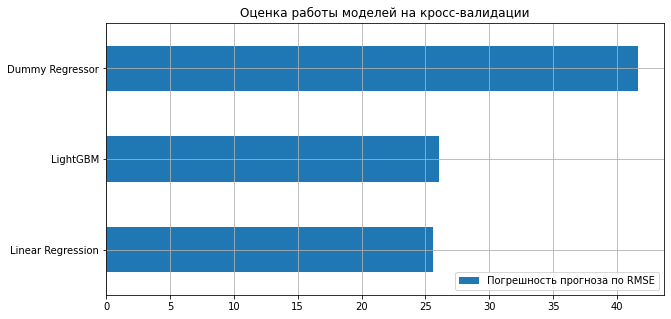

In [35]:
results = pd.DataFrame({'Погрешность прогноза по RMSE': scores}, index=names)
display(results)
results.plot(kind='barh',title='Оценка работы моделей на кросс-валидации',
            figsize=(10,5),grid=True);

**Вывод:** 

Я построила две регрессионные модели предсказания временных рядов: линейную регрессию и LightGBM.

Обе модели прошли порог адекватности по метрике RMSE, оцененной кросс-валидацией, меньше 41 - погрешности константной модели.

Также модели показали почти одинаковые результаты, но лучше все равно справилась линейная регрессия. Проверю эту модель на тестовой выборке. 

## Тестирование

RMSE Линейной регрессии на тестовой выборке 43.13044500379368


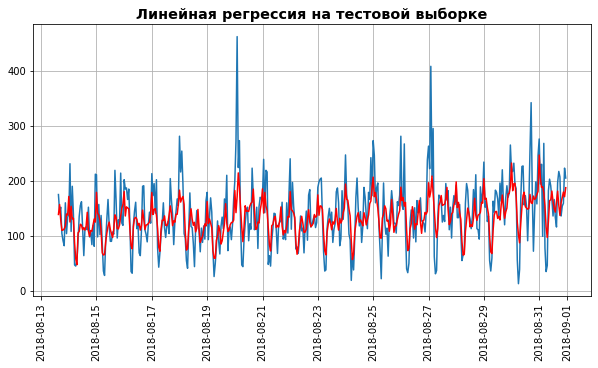

In [36]:
lr.fit(X_train,y_train)
preds = lr.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)

print('RMSE Линейной регрессии на тестовой выборке', rmse)

plt.figure(figsize=(10,5))
plt.plot(X_test.index,y_test)
plt.plot(X_test.index,preds,color='red')
plt.title('Линейная регрессия на тестовой выборке',fontweight='bold',fontsize='x-large')
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Итоговый вывод

Целью данного проекта являлось построение модели для прогнозирования спроса такси в аэропорту на следующий час по имеющимся данным за 6 месяцев.

Я проанализировала временной ряд при помощи инстументов statmodels. Был обнаружен явный тренд, демонстрирующий сильное повышение спроса на такси за этот период. Также были обнаружены сезонные компоненты в сутках и неделе. Шум показал, что в данных есть выбросы.

Я использовала классические регрессионные модели: линейную модель и LightGBM. В качестве признаков были переданы категориальные значения, содержащие в себе информацию о часе и сутках - по этим признакам модель учитывала сезонные состовлящие. В качестве количественных признаков были переданы скользящие средние, отстающие значения и разности временного ряда, все признаки с окном в 12 часов. Модели, обученные на таких признаках, могут делать прогноз на 12 часов вперед по имеющимся данным.

Обе модели показали примерно одинаковый результат на кросс-валидации - 26. Метрикой оценки служил RMSE. 

Я проверила работу модели на тестовой выборке - RMSE составил 43. Порог в 48 от заказчика пройден.